# Patterns in Performance: Clustering High School Student Math Course Data

**Names**: Aleksandra Grigortsuk, Wendy Zheng, Yinglei Wu, Xiangrui Deng

## 1. Introduction

Education plays an important role in shaping individuals as well as our societies, shaping students' personal growth in academic and emotional intelligence. Schools aim to measure academic intelligence, grades indicating the measure of acheivement, dedication, and understanding. But not everyone has the equal opportunity to get good grades. By looking at a dataset of Portuguese high school demographics and math course performance, we aim to idenfity through clustering leading factors that could negatively impact a student's final grades. Through the insight we gain by clustering, we can make more informed decisions about teaching and offering help to students who face specific challenges that may or may not be in the student's control. 

Citations:
* https://www.kaggle.com/datasets/dillonmyrick/high-school-student-performance-and-demographics/
* https://arxiv.org/ftp/arxiv/papers/2301/2301.03421.pdf
* https://builtin.com/data-science/data-clustering-python


## 2. Dataset Discussion

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
df = pd.read_csv('student_math_clean.csv')
df.head(5)

,student_id,school,sex,age,address_type,family_size,parent_status,mother_education,father_education,mother_job,...,family_relationship,free_time,social,weekday_alcohol,weekend_alcohol,health,absences,grade_1,grade_2,final_grade
0,1,GP,F,18,Urban,Greater than 3,Apart,higher education,higher education,at_home,...,4,3,4,1,1,3,6,5,6,6
1,2,GP,F,17,Urban,Greater than 3,Living together,primary education (4th grade),primary education (4th grade),at_home,...,5,3,3,1,1,3,4,5,5,6
2,3,GP,F,15,Urban,Less than or equal to 3,Living together,primary education (4th grade),primary education (4th grade),at_home,...,4,3,2,2,3,3,10,7,8,10
3,4,GP,F,15,Urban,Greater than 3,Living together,higher education,5th to 9th grade,health,...,3,2,2,1,1,5,2,15,14,15
4,5,GP,F,16,Urban,Greater than 3,Living together,secondary education,secondary education,other,...,4,3,2,1,2,5,4,6,10,10


In [3]:
df.shape[0]

395

In [4]:
df_GP = df[df['school'] == 'GP']
df_GP.shape[0]

349

The dataset was downloaded from Kaggle (https://www.kaggle.com/datasets/dillonmyrick/high-school-student-performance-and-demographics), downloaded on November 16, 2023. From the website, the row observations in the dataset represents each students' attribute, i.e. age, sex, internet, etc. This data was collected using school reports and questionnaires, and includes student grades, demographics, social, parent, and school-related features. This dataset contains most of the features that are important in predicting students' grade. However, some feature that might be left out are students' mental health, participation, past-grades, etc. These features might be important in predicting students' grade, and thus, might impact the types of actions that the person in our research motivation might take based on the answer to our research questions. We focus on their math grades and focus only on the school 'GP'. The original dataset has 395 observations, after subsetting school 'GP', there are 349 observations. The variable 'student_id' could be dropped because it's not important for our research goals. The variable we intend to use are 'sex', 'age', 'family_size', 'parents_status', 'mother_education', 'father_education', and many more they have included in the dataset. Most of the variables are categorical. For example, mother_education has categories: higher education, secondary education, etc. And, for binary variables like 'activities' and 'internet_access', they are either yes or no. From those variables, we can further investigate our research questions.

## 3. Dataset Cleaning and Exploration

### Subset the data
1. Only include 'GP' in the school
2. Assign Letter grade to final grade

In [5]:
# Identify Missing values
df_subset = df[df['school'] == 'GP']
quality_map = {'low': 0, 'medium': 1, 'high': 2}

bins = [0,9,13,15,17,20]
labels=['F','C','B','A','A+']
df_subset['letter_grade'] = pd.cut(df_subset['final_grade'], bins=bins, labels=labels, include_lowest=True)

print(df_subset.isnull().any().any())

#df_subset.to_csv("../../letter_grade.csv")

False


### Missing Values Results 
1. As is indicated in the answer above, there are no missing values in this particular dataset. 

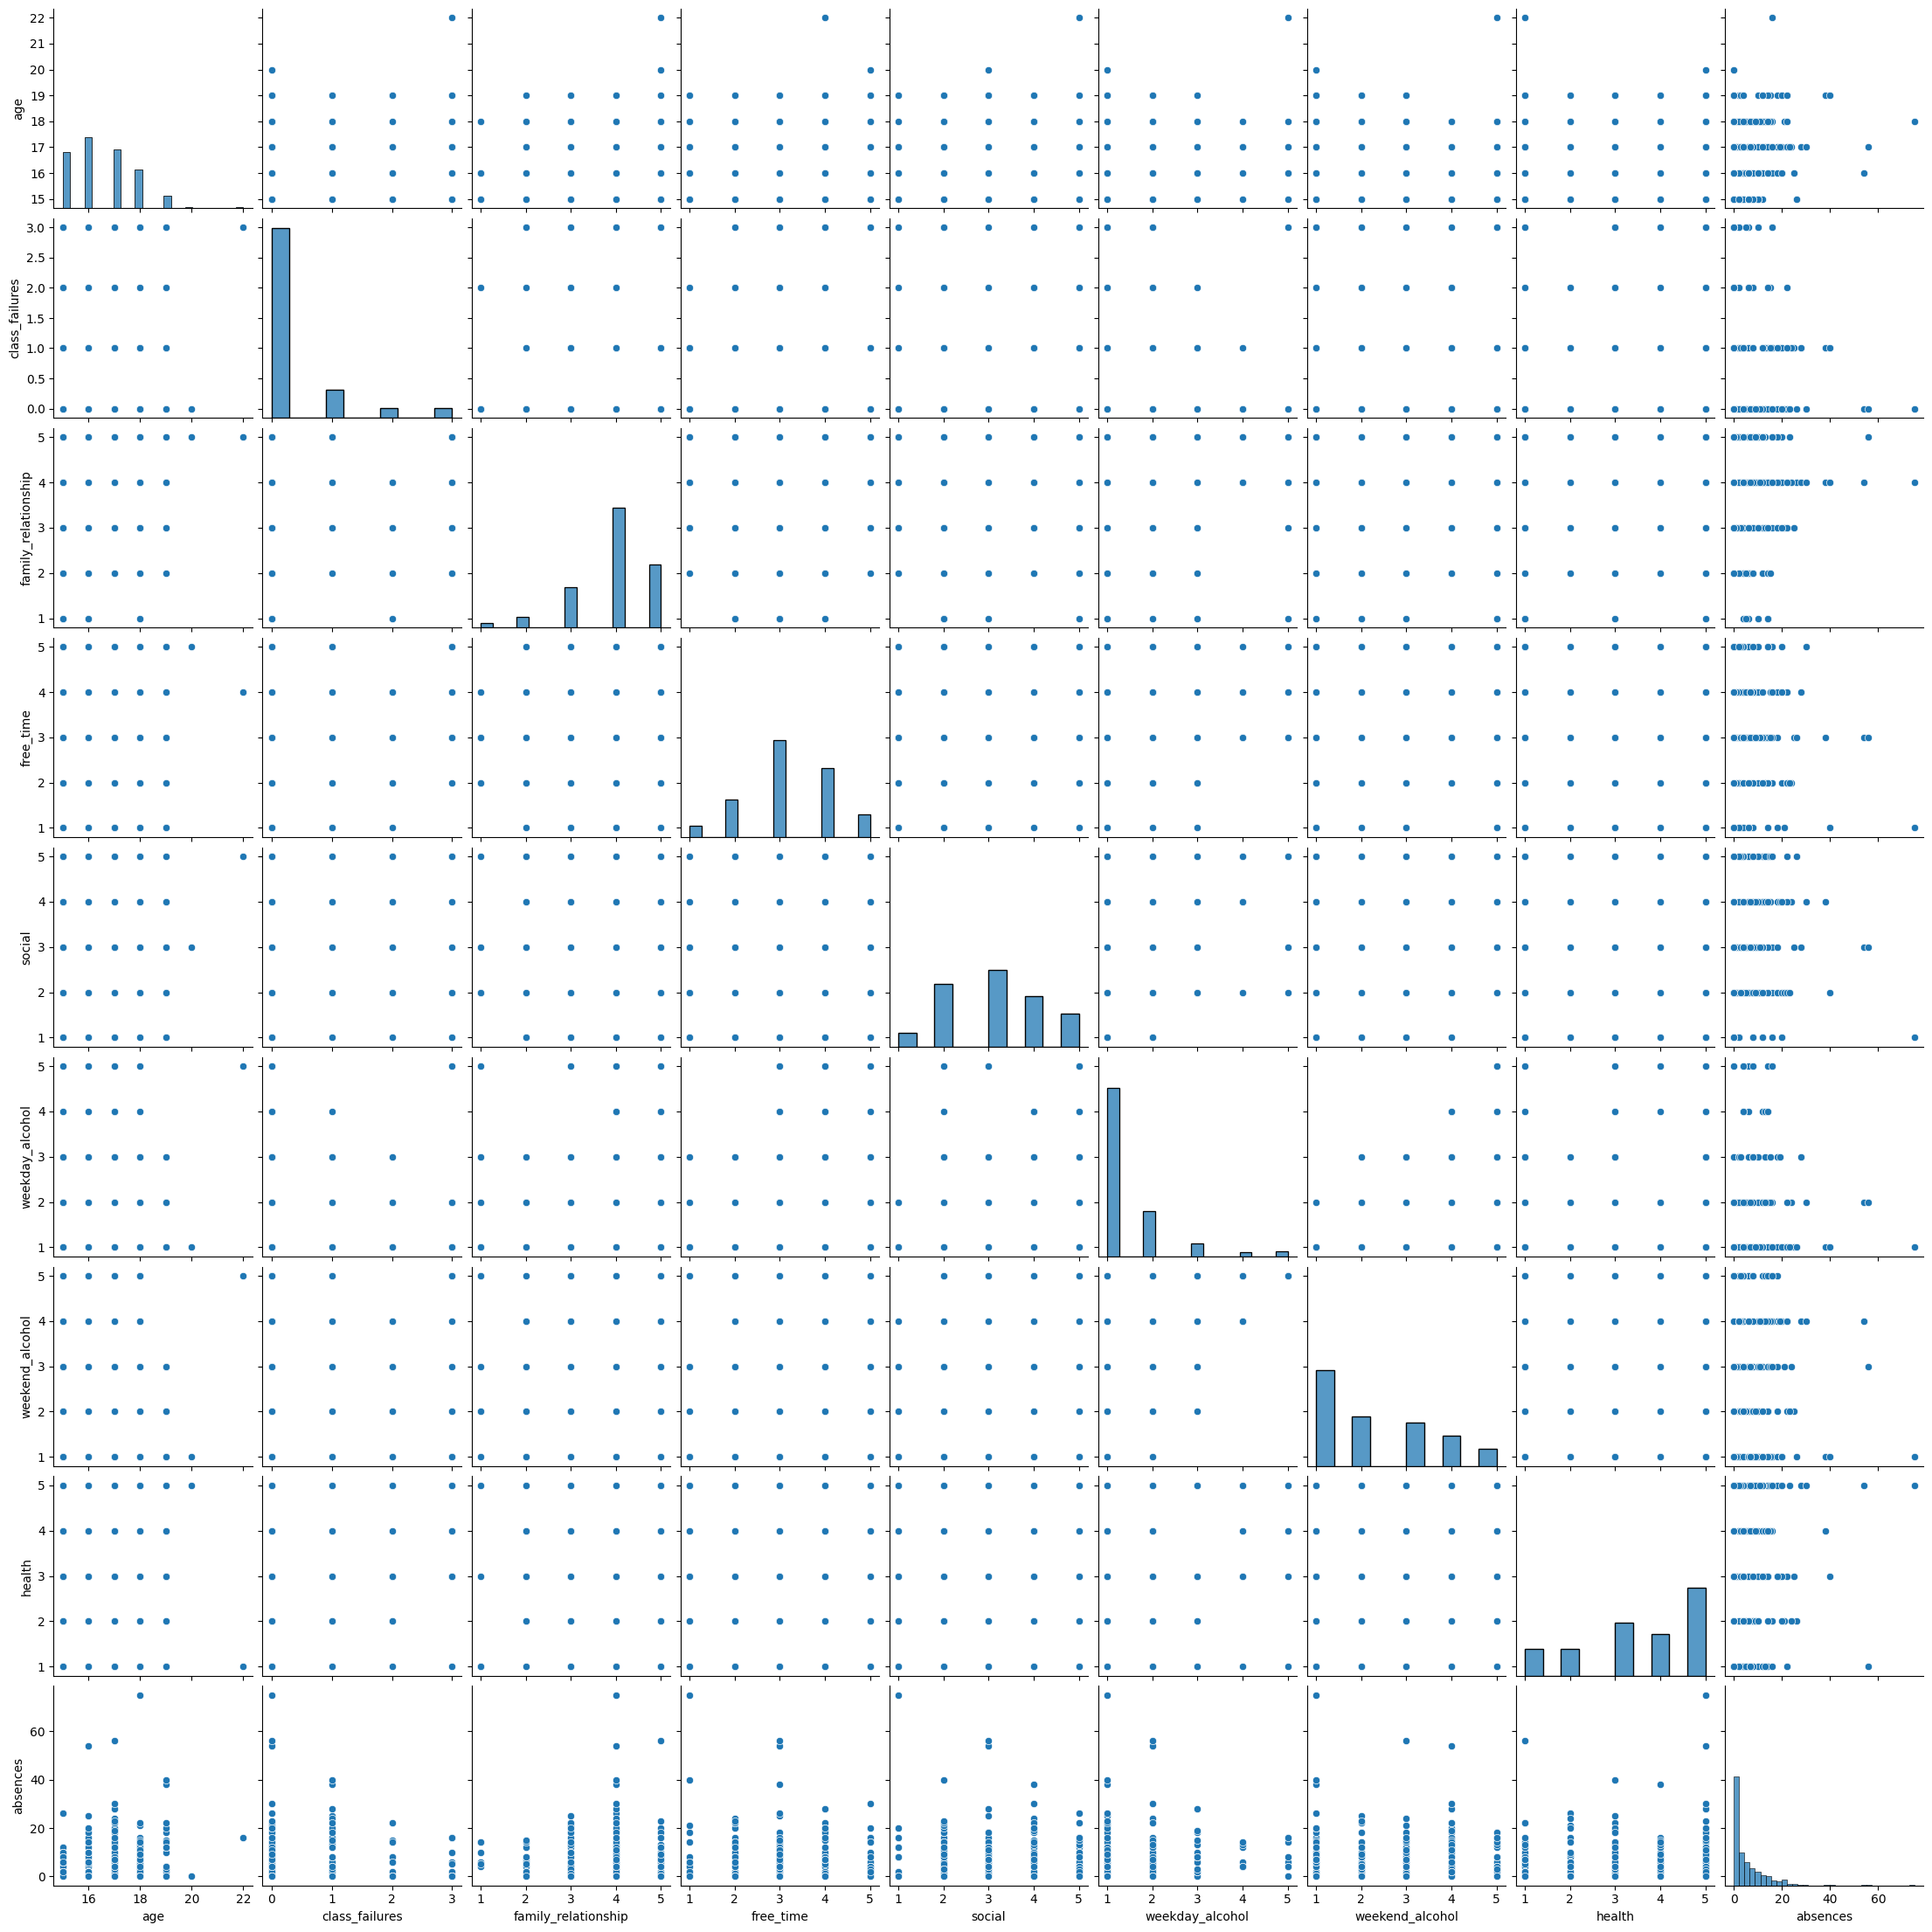

In [6]:
# Now, we would like to create a pair plot on all the numerical variables
df_numerical = df_subset[['age', 'class_failures','family_relationship','free_time', 'social', 'weekday_alcohol','weekend_alcohol','health','absences']]
sns.pairplot(data=df_numerical)

### Pairwise Scatterplot Results
1. Because most of the numerical values only have interger values, the pairplots between two variables are grids. 
2. It seems that there are not significant outliers in most of the variables except for absences. A few outliers exist with high values (over 40) of absences. 

### Dendrograms for Outlier Detection

Next, we would like to detect high-dimensional outliers with single-linkage dendrograms. The single-linkage dendrogram algorithm is more likely to detect outliers than the average-linkage or complete-linkage algorithms.


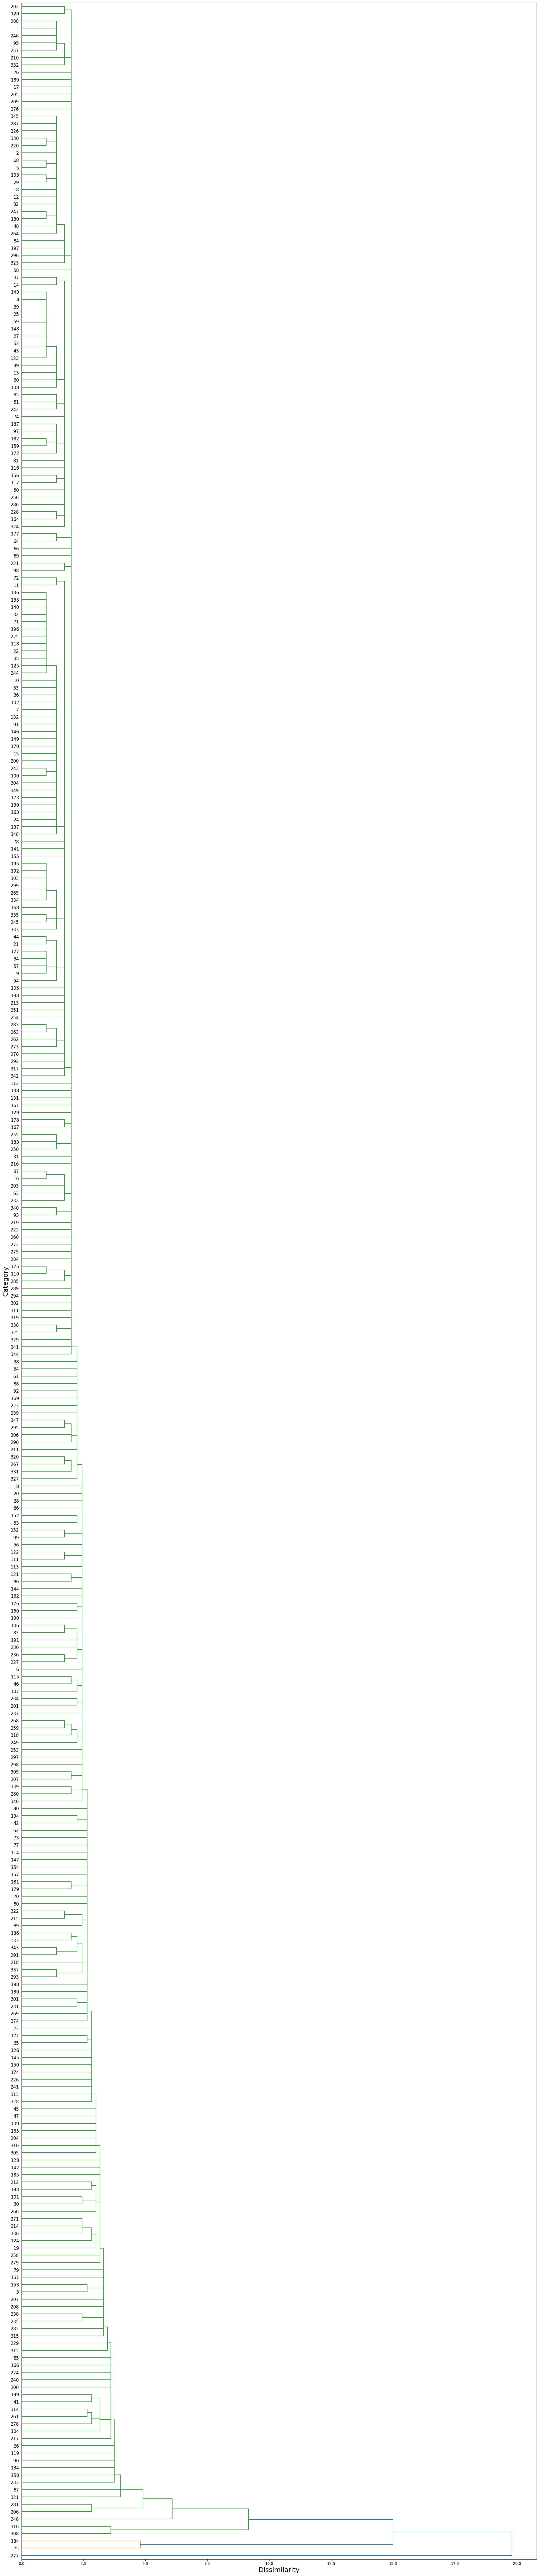

In [7]:
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

dm = pdist(df_numerical, metric='euclidean')
Z = linkage(dm, method='single')

fig, ax = plt.subplots(figsize=(25, 125))
d = dendrogram(Z, orientation='right', labels=df_subset['student_id'].array, ax=ax)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('Category', fontsize=18)
plt.yticks(fontsize=12)
plt.show()

### Outlier Identification with Single-Linkage Dendrogram Results

According to the dendrogram, the student with ID **227** forms a singleton cluster, and the students with ID **184** and **75** form another subcluster that's separated from the other observations. We consider these three observations as outliers and will drop them for further analysis.

#### Explanation

Because our research goal is to cluster students' final grades based on their private information, the three outliers might bias the interpretation of some predictors on the final clustering results. The pros of dropping them is that we can draw general conclusions from the dataset which meets our research goals. However, the cons are that the final clustering algorithms might not be robust as they do not take into account marginal cases.

### Noise Detection
We will first remove the aforementioned outliers and detect noises for the rest of the dataset.

Then, to check for data noises, we plot the k=2, ..., k=9 distance plot

(346, 9)


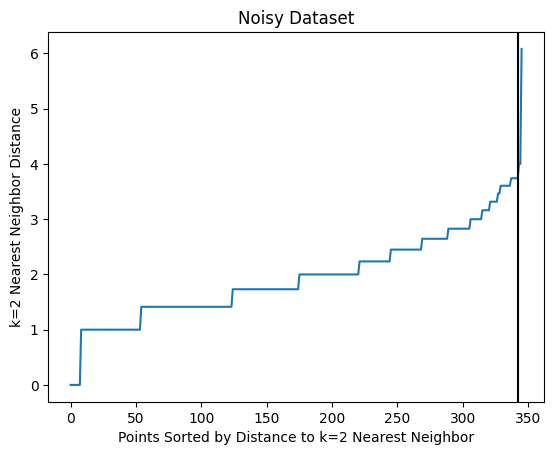

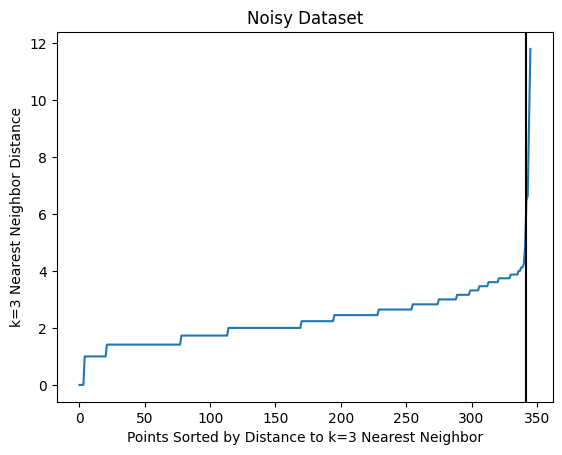

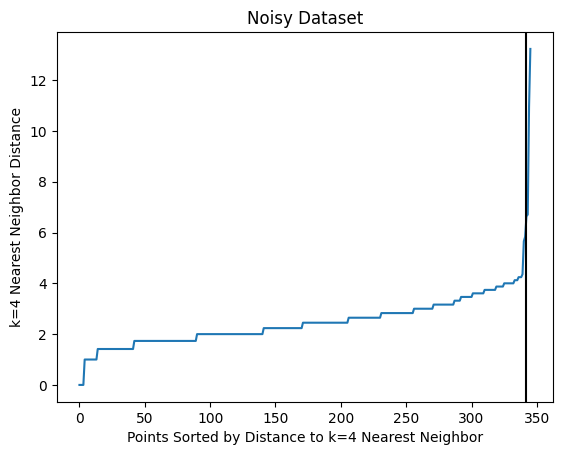

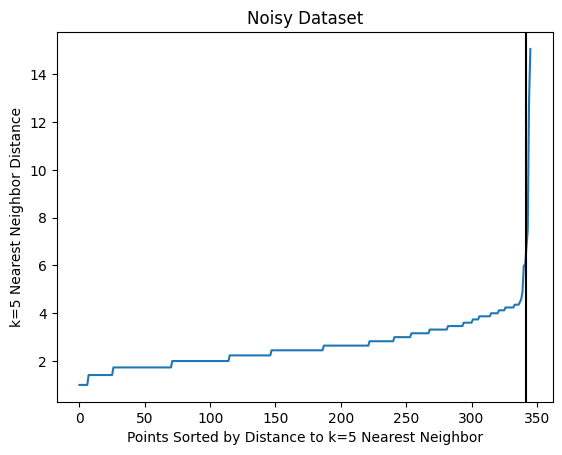

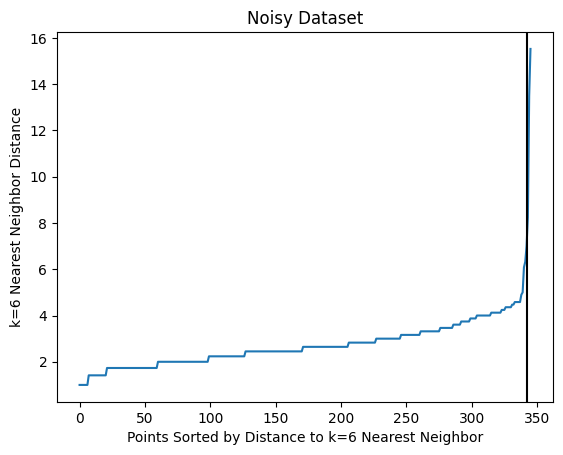

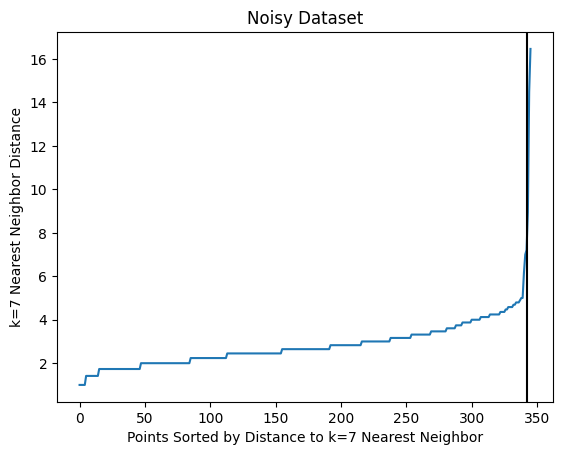

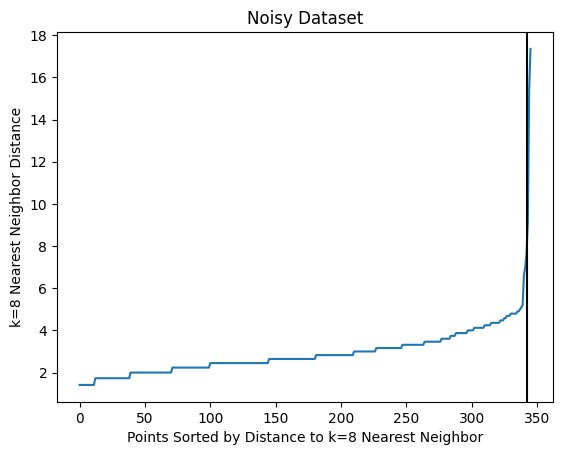

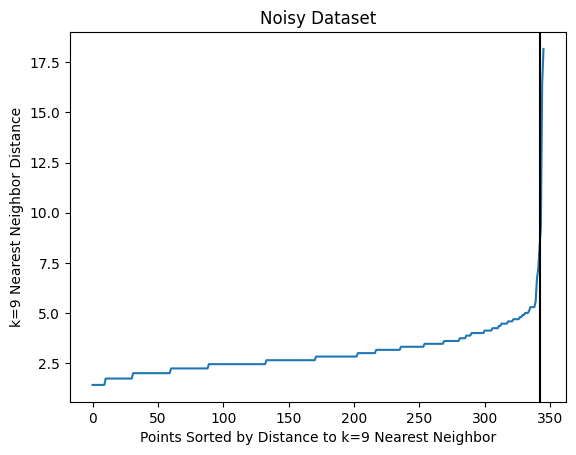

In [8]:
# Filter df
df_subset_outlier_removal = df_subset[~df_subset['student_id'].isin([184, 75, 277])]

X_numerical = df_subset_outlier_removal[['age', 'class_failures','family_relationship','free_time', 'social', 'weekday_alcohol','weekend_alcohol','health','absences']]
print(X_numerical.shape)

from sklearn.neighbors import NearestNeighbors
#Find the distance of the kth nearest neighbor
for k in range(2,10):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X_numerical)
    distances, indices = nbrs.kneighbors(X_numerical)

    plt.plot(np.sort(distances.T[k-1]))
    plt.axvline(x=342, color='black')
    plt.xlabel('Points Sorted by Distance to k=%s Nearest Neighbor'%k)
    plt.ylabel('k=%s Nearest Neighbor Distance'%k)
    plt.title('Noisy Dataset')
    plt.show()

### Noisy Data Conclusion

For k=2...k=9 nearest neighbor plots, there is a dramatic jump in nearest neighbor distances when the number of observations is 342, which indicates that 6 noisy data points exist in the current dataset. Based on the information of noisy data obtained, we can pick reasonable values of $\epsilon$ when using DBSCAN algorithms for clustering. For example, in the k=9 plot, the nearest neighbor value jumps at roughly 7.5, we will set $\epsilon$ as 7.5 if we set minpts as 9 in the DBSCAN algorithm.

In [22]:
# dummy coding string variables
non_numeric_columns = df_subset_outlier_removal.select_dtypes(exclude=['number']).columns
numeric_columns = df_subset_outlier_removal.select_dtypes(include=['number']).columns

df_dummies = pd.get_dummies(df_subset_outlier_removal, columns=non_numeric_columns)
df_final = pd.concat([df_subset_outlier_removal[numeric_columns], df_dummies], axis=1)

df_dummies.head()

,student_id,age,class_failures,family_relationship,free_time,social,weekday_alcohol,weekend_alcohol,health,absences,...,higher_ed_yes,internet_access_no,internet_access_yes,romantic_relationship_no,romantic_relationship_yes,letter_grade_F,letter_grade_C,letter_grade_B,letter_grade_A,letter_grade_A+
0,1,18,0,4,3,4,1,1,3,6,...,1,1,0,1,0,1,0,0,0,0
1,2,17,0,5,3,3,1,1,3,4,...,1,0,1,1,0,1,0,0,0,0
2,3,15,3,4,3,2,2,3,3,10,...,1,0,1,1,0,0,1,0,0,0
3,4,15,0,3,2,2,1,1,5,2,...,1,0,1,0,1,0,0,1,0,0
4,5,16,0,4,3,2,1,2,5,4,...,1,1,0,1,0,0,1,0,0,0


## 4. Basic Descriptive Analytics

In [23]:
#seperate numerical data 
df_num = df_dummies.select_dtypes(include = ['float64', 'int64'])
#remove "student_id" column
df_num = df_num.drop(['student_id'], axis=1)

#summary of the numerical data
df_num.describe()

,age,class_failures,family_relationship,free_time,social,weekday_alcohol,weekend_alcohol,health,absences,grade_1,grade_2,final_grade
count,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000
mean,16.517341,0.320809,3.956647,3.231214,3.118497,1.442197,2.257225,3.575145,5.482659,10.947977,10.789017,10.500000
std,1.218690,0.736994,0.875346,0.983196,1.121776,0.860307,1.307844,1.377402,6.496018,3.331476,3.821980,4.642744
min,15.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,16.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,17.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,40.000000,19.000000,19.000000,20.000000


In [25]:
#seperate the categorical data
df_cat = df_subset_outlier_removal.select_dtypes(include = ['object'])
df_cat.head()

#summary of the categorical data
df_cat.describe()

,school,sex,address_type,family_size,parent_status,mother_education,father_education,mother_job,father_job,school_choice_reason,...,travel_time,study_time,school_support,family_support,extra_paid_classes,activities,nursery_school,higher_ed,internet_access,romantic_relationship
count,346,346,346,346,346,346,346,346,346,346,...,346,346,346,346,346,346,346,346,346,346
unique,1,2,2,2,2,5,5,5,5,4,...,4,4,2,2,2,2,2,2,2,2
top,GP,F,Urban,Greater than 3,Living together,higher education,5th to 9th grade,other,other,course,...,<15 min.,2 to 5 hours,no,yes,no,yes,yes,yes,yes,no
freq,346,180,284,250,309,120,102,119,195,124,...,241,173,296,222,186,183,280,330,294,235


[('weekday_alcohol', 'weekend_alcohol'),
 ('weekend_alcohol', 'weekday_alcohol'),
 ('grade_1', 'grade_2'),
 ('grade_1', 'final_grade'),
 ('grade_2', 'grade_1'),
 ('grade_2', 'final_grade'),
 ('final_grade', 'grade_1'),
 ('final_grade', 'grade_2')]

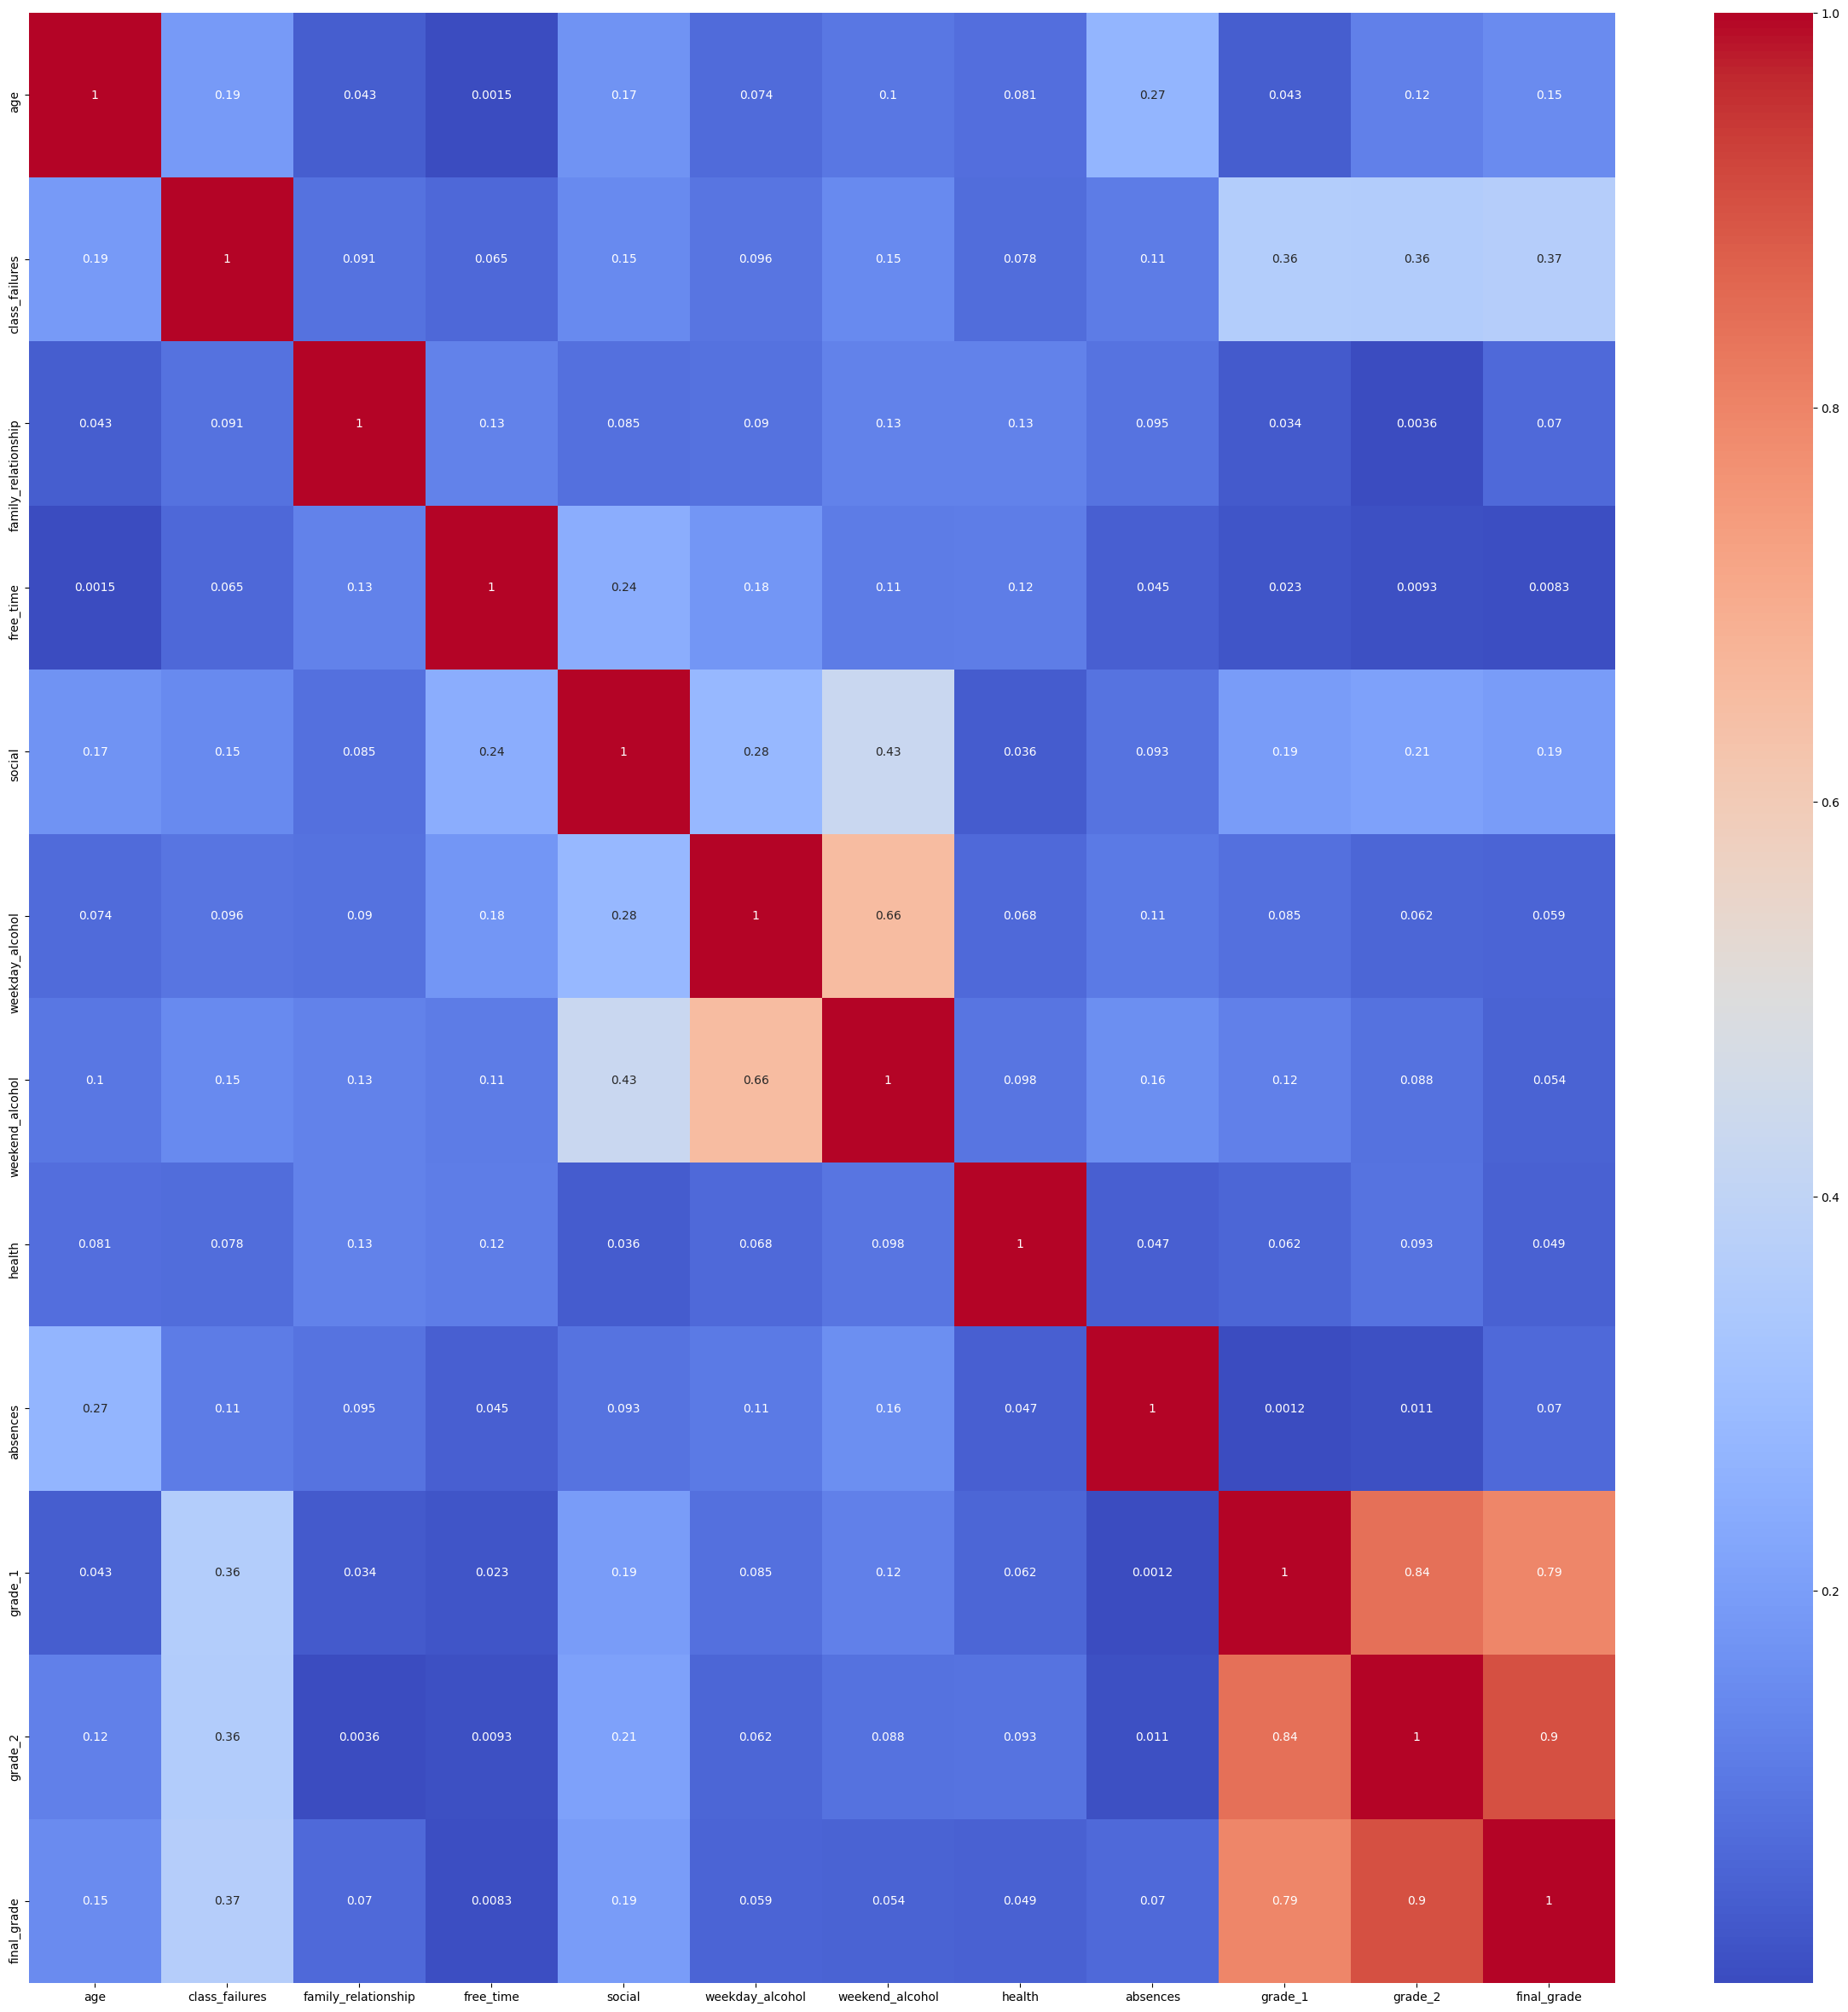

In [26]:
#pairwise correlation of numerical data
df_num_corr = df_num.corr()
df_num_corr

#heatmap of the correlation
fig, ax = plt.subplots(figsize = (30, 30))
sns.heatmap(abs(df_num_corr), annot = True, cmap = 'coolwarm')

high_corr_pairs = [(column, correlated_column) 
                   for column in df_num_corr.columns 
                   for correlated_column in  df_num_corr.columns 
                   if (abs(df_num_corr.loc[column, correlated_column]) > 0.5) and (column != correlated_column)]

high_corr_pairs


Grade 1 is highly correlated with grade 2 and final grade. Alcohol consumption patterns (weekday_alcohol and weekend_alcohol) are also correlated, otherwise there aren't many numerical pairwise correlation.

<Axes: >

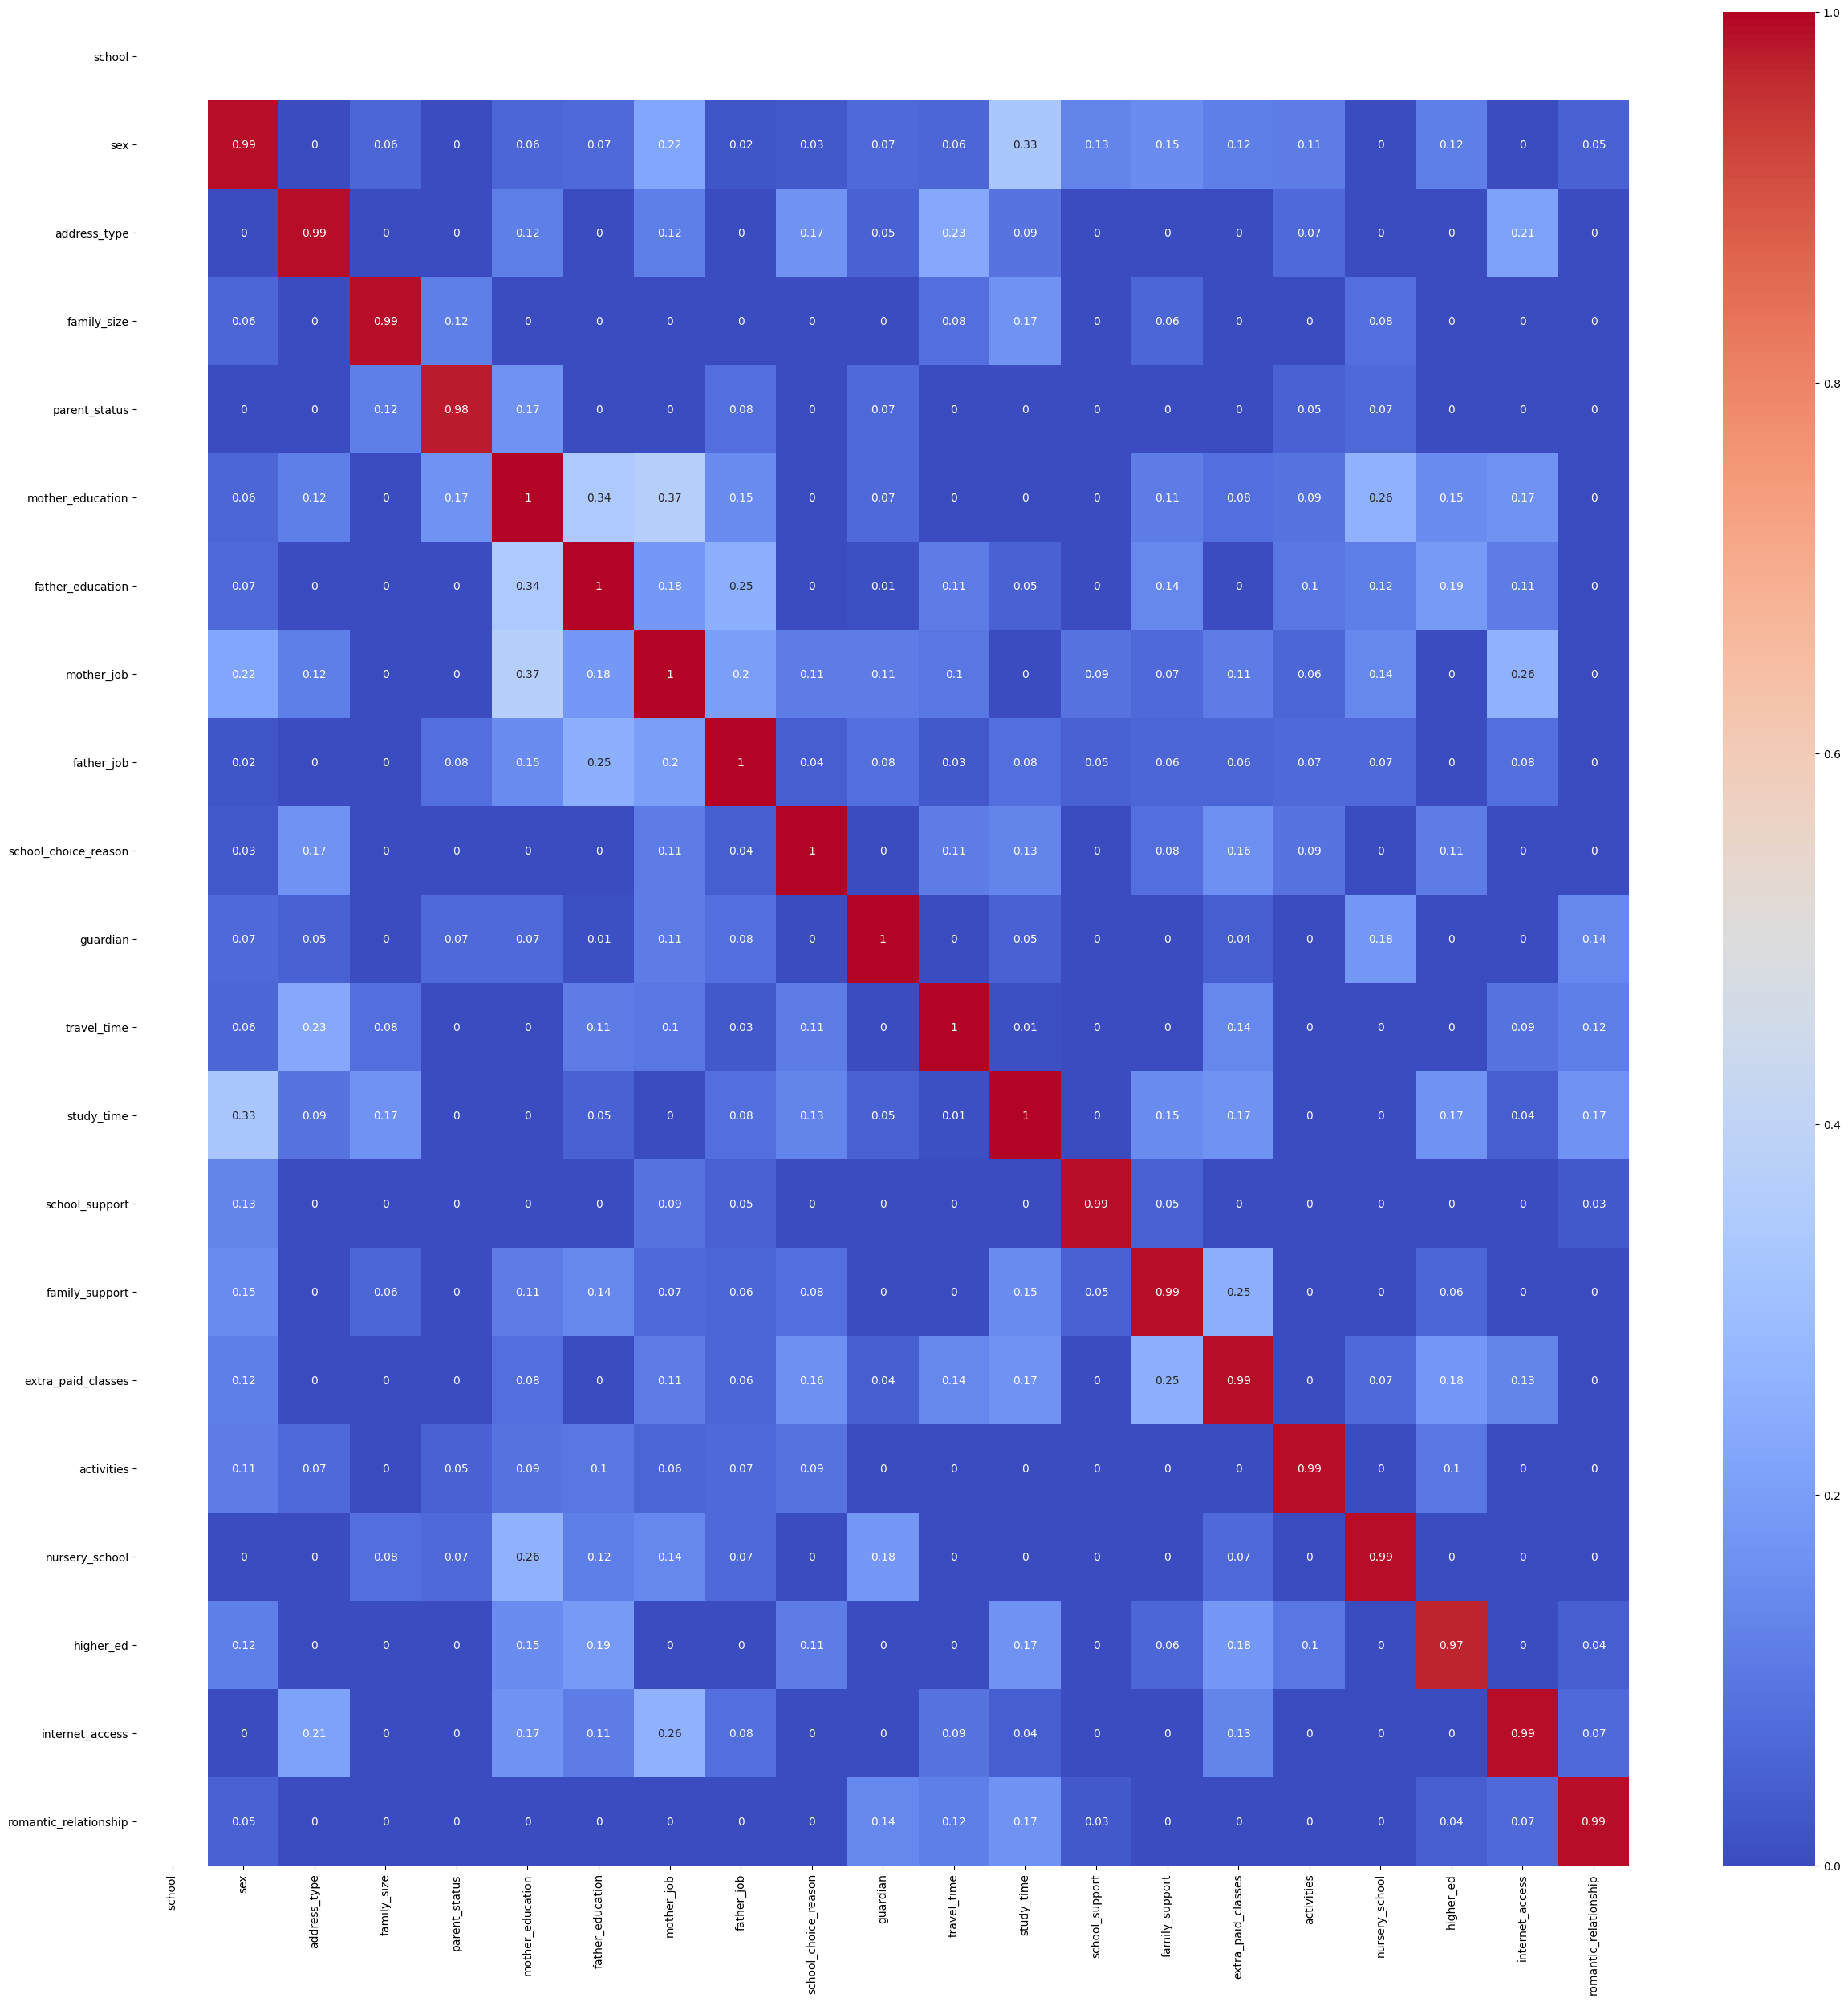

In [27]:
#contingency table for categorical variables
import pandas as pd
from scipy.stats import chi2_contingency

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

#pairwise correlation of categorical data
rows= []

for var1 in df_cat:
    col = []
    for var2 in df_cat :
        cramers =cramers_corrected_stat(pd.crosstab(df_cat[var1], df_cat[var2]))
        col.append(round(cramers,2)) # Keeping of to two decimal
    rows.append(col)

cramers_results = np.array(rows)
df_cat_corr = pd.DataFrame(cramers_results, columns = df_cat.columns, index =df_cat.columns)

#heatmap of the correlation
fig, ax = plt.subplots(figsize = (30, 30))
sns.heatmap(abs(df_cat_corr), annot = True, cmap = 'coolwarm')



According to the heatmap, the categorical variables does not have significant pairwise correlation.

<Axes: >

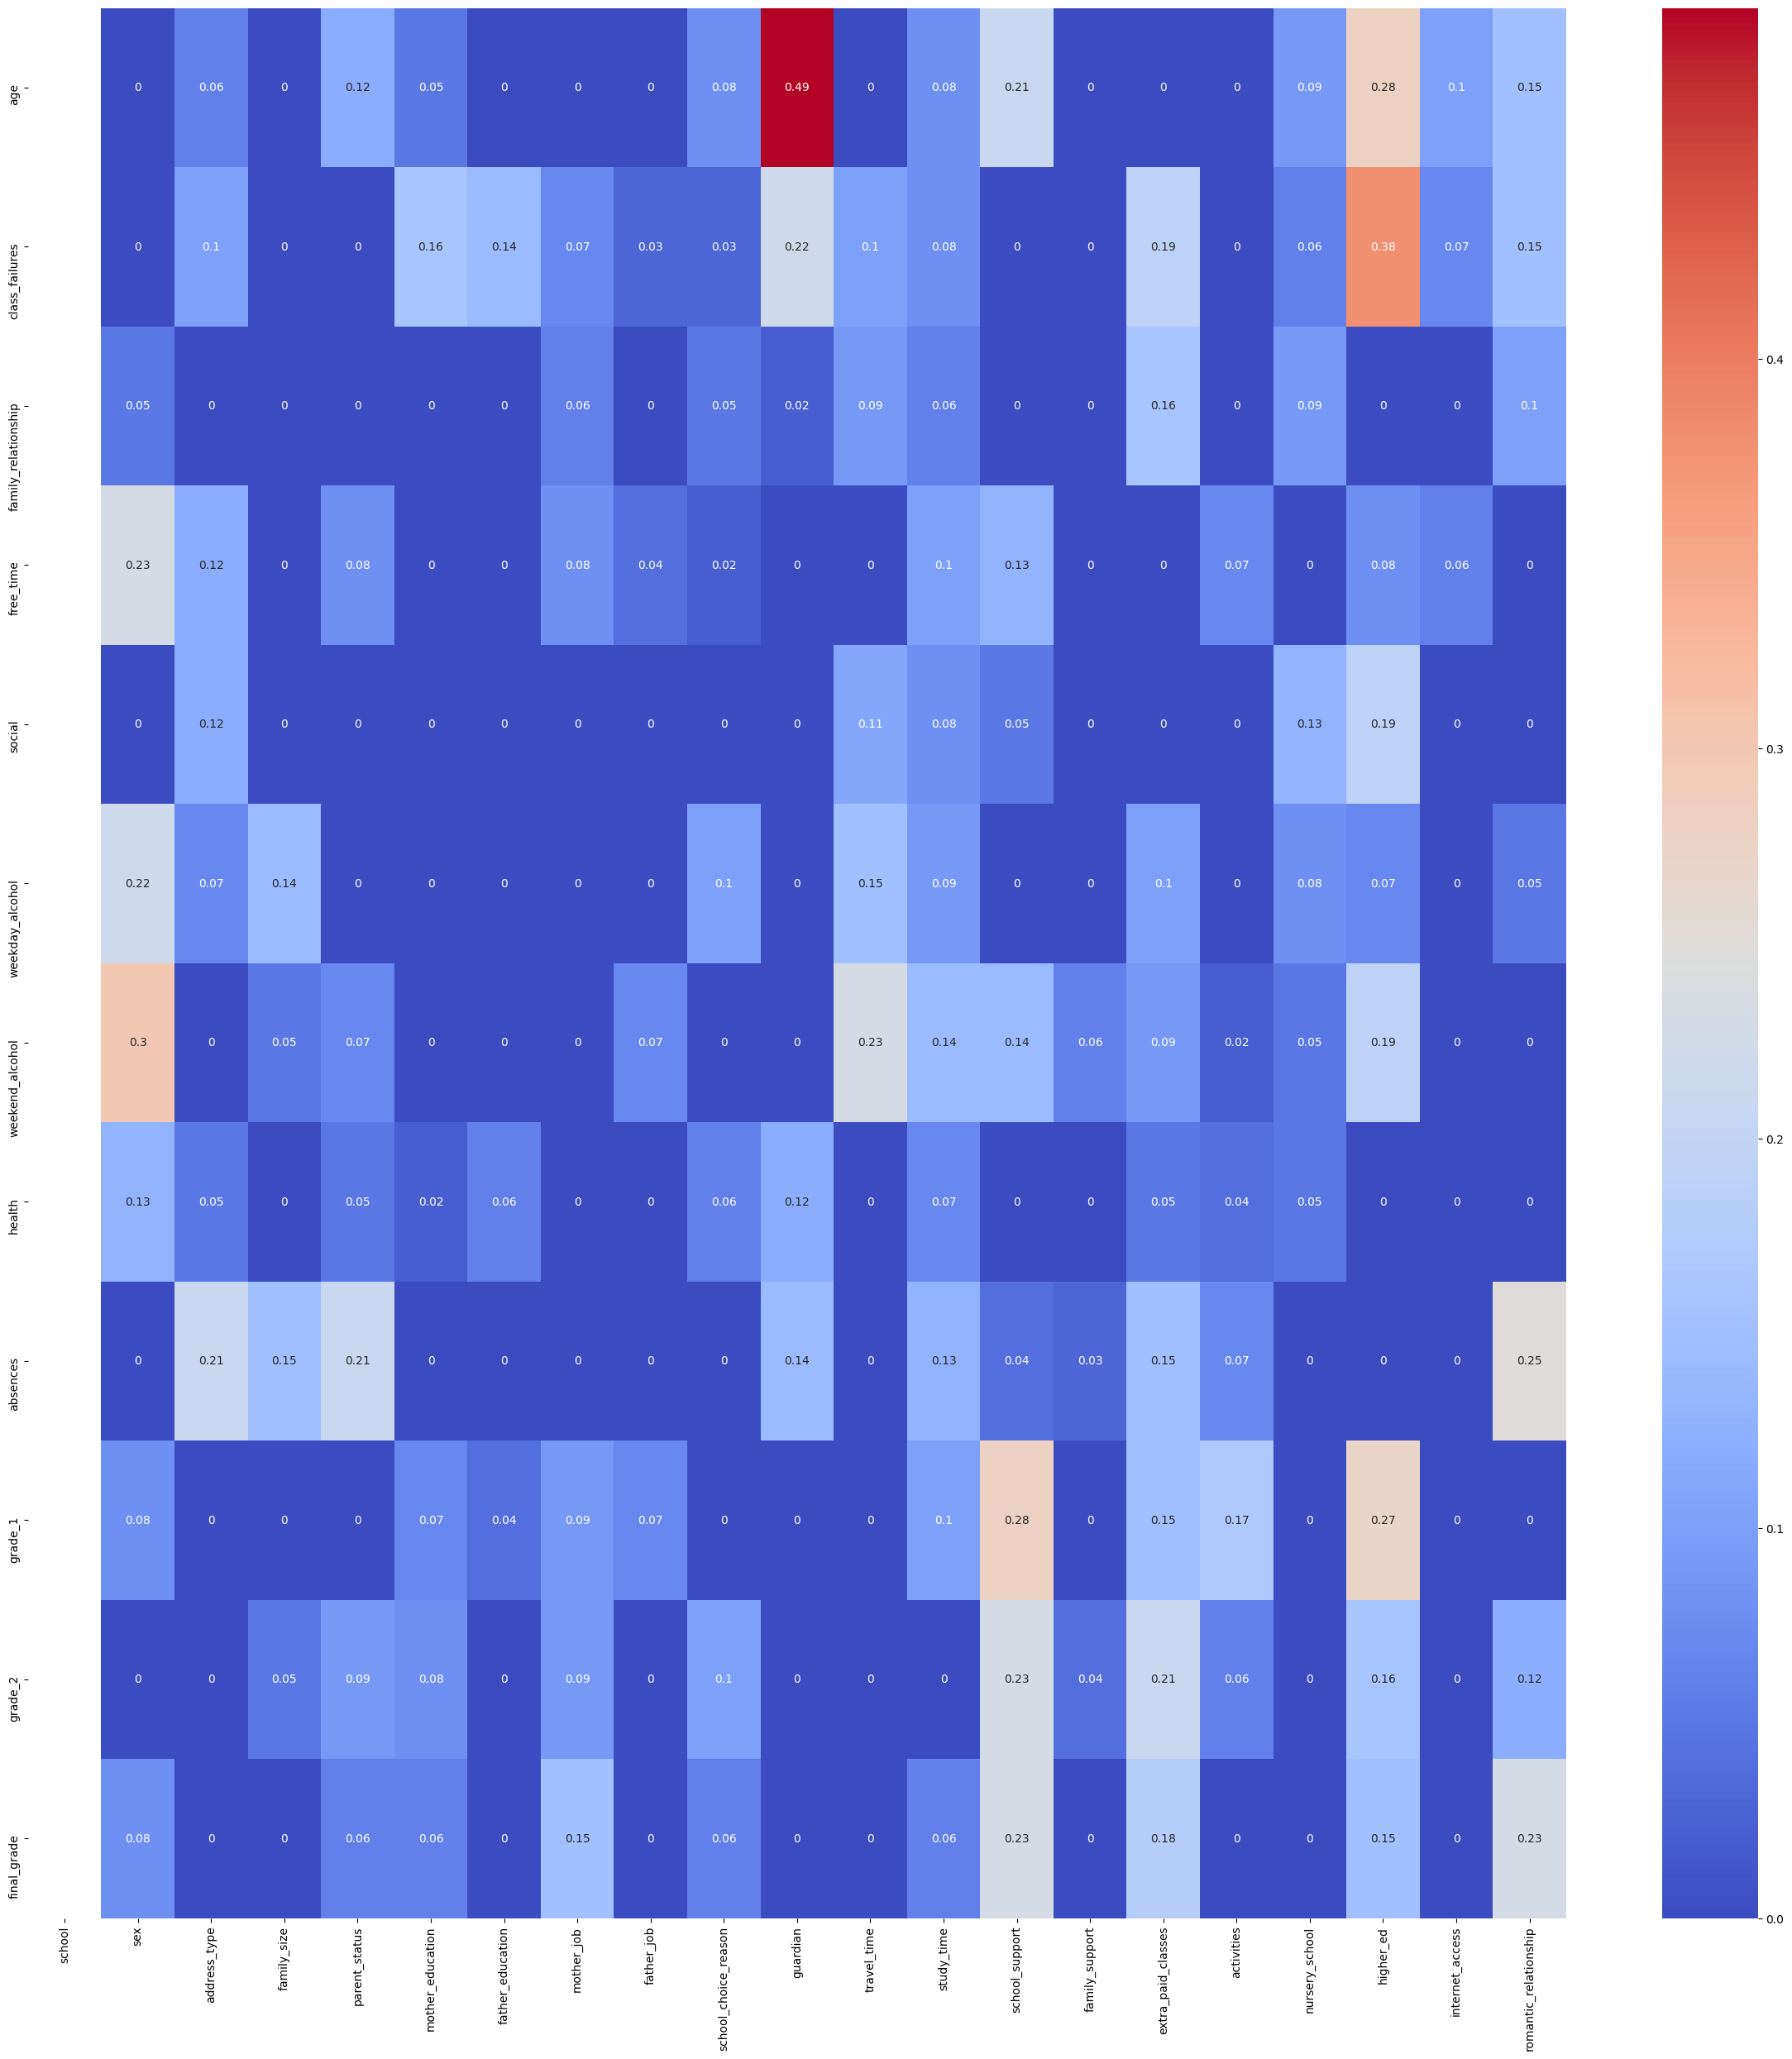

In [28]:
#pairwise relationship between numerical variables and categorical varaiables
rows = []

for var1 in df_num:
    col = []
    for var2 in df_cat :
        cramers =cramers_corrected_stat(pd.crosstab(df_num[var1], df_cat[var2]))
        col.append(round(cramers,2)) # Keeping of to two decimal
    rows.append(col)

cramers_results = np.array(rows)
df_num_cat_corr = pd.DataFrame(cramers_results, columns = df_cat.columns, index =df_num.columns)

#heatmap of the correlation
fig, ax = plt.subplots(figsize = (30, 30))
sns.heatmap(abs(df_num_cat_corr), annot = True, cmap = 'coolwarm')


For numerical and categorical variables, we can see that there guardian is correlated with age, but otherwise there's not much correlation between numerical and categorical variables.

## 5. Scaling Decisions

We want to standardize the dataset, since some features have a higher std that can negatively impact the clustering model results. By scaling the data, it would normalize stds to be lower.

In [29]:
from sklearn.preprocessing import StandardScaler

df_dummies.describe()
X = df_dummies.copy()
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

df_scaled.describe()

,student_id,age,class_failures,family_relationship,free_time,social,weekday_alcohol,weekend_alcohol,health,absences,...,higher_ed_yes,internet_access_no,internet_access_yes,romantic_relationship_no,romantic_relationship_yes,letter_grade_F,letter_grade_C,letter_grade_B,letter_grade_A,letter_grade_A+
count,3.460000e+02,3.460000e+02,3.460000e+02,3.460000e+02,3.460000e+02,3.460000e+02,3.460000e+02,346.000000,3.460000e+02,3.460000e+02,...,3.460000e+02,346.000000,3.460000e+02,3.460000e+02,3.460000e+02,3.460000e+02,3.460000e+02,3.460000e+02,3.460000e+02,3.460000e+02
mean,-8.214367e-17,1.150011e-15,9.241163e-17,8.599415e-17,1.026796e-16,-6.674173e-17,6.674173e-17,0.000000,-1.026796e-17,6.160775e-17,...,-1.386174e-16,0.000000,7.700969e-17,3.080388e-17,1.026796e-16,7.187571e-17,-2.823689e-17,-7.187571e-17,-8.342716e-18,-6.674173e-17
std,1.001448e+00,1.001448e+00,1.001448e+00,1.001448e+00,1.001448e+00,1.001448e+00,1.001448e+00,1.001448,1.001448e+00,1.001448e+00,...,1.001448e+00,1.001448,1.001448e+00,1.001448e+00,1.001448e+00,1.001448e+00,1.001448e+00,1.001448e+00,1.001448e+00,1.001448e+00
min,-1.724335e+00,-1.246862e+00,-4.359247e-01,-3.382581e+00,-2.272634e+00,-1.891256e+00,-5.147432e-01,-0.962689,-1.872274e+00,-8.452254e-01,...,-4.541476e+00,-0.420560,-2.377782e+00,-1.455032e+00,-6.872703e-01,-6.872703e-01,-8.343131e-01,-4.394354e-01,-2.476887e-01,-2.273142e-01
25%,-8.595319e-01,-4.251206e-01,-4.359247e-01,4.959796e-02,-2.355061e-01,-9.985210e-01,-5.147432e-01,-0.962689,-4.181623e-01,-8.452254e-01,...,2.201928e-01,-0.420560,4.205600e-01,-1.455032e+00,-6.872703e-01,-6.872703e-01,-8.343131e-01,-4.394354e-01,-2.476887e-01,-2.273142e-01
50%,-4.640776e-03,-4.251206e-01,-4.359247e-01,4.959796e-02,-2.355061e-01,-1.057865e-01,-5.147432e-01,-0.196964,3.088937e-01,-2.285717e-01,...,2.201928e-01,-0.420560,4.205600e-01,6.872703e-01,-6.872703e-01,-6.872703e-01,-8.343131e-01,-4.394354e-01,-2.476887e-01,-2.273142e-01
75%,8.601622e-01,3.966209e-01,-4.359247e-01,1.193658e+00,7.830577e-01,7.869481e-01,6.493166e-01,0.568761,1.035950e+00,3.880819e-01,...,2.201928e-01,-0.420560,4.205600e-01,6.872703e-01,1.455032e+00,1.455032e+00,1.198591e+00,-4.394354e-01,-2.476887e-01,-2.273142e-01
max,1.724965e+00,4.505328e+00,3.640561e+00,1.193658e+00,1.801622e+00,1.679683e+00,4.141496e+00,2.100210,1.035950e+00,5.321311e+00,...,2.201928e-01,2.377782,4.205600e-01,6.872703e-01,1.455032e+00,1.455032e+00,1.198591e+00,2.275647e+00,4.037326e+00,4.399198e+00


## 6. Clusterability and Clustering Structure

## 7. Clustering Algorithm Selection Motivation

## 8. Clustering Algorithm Practical Considerations

## 9. Clustering Algorithm #1



## 10. Clustering Algorithm #2

## 11. Discussion

## 12. Conclusion

## References